In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
import optuna
import os

c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor



In [4]:
# 乱数シードの設定
def set_random_seed(seed_value=42):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    random.seed(seed_value)
    
set_random_seed(42)

In [5]:
# ボストンの住宅価格データセットをロード
# data_urlにはKaggleなどからダウンロードしたデータセットのパスを指定
data_url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
data = pd.read_csv(data_url)

In [6]:
# 値段の中央値を目的変数に設定
X = data.drop('medv',axis=1)
Y = data.medv

In [7]:
# データセットの分割
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [8]:
# 正規化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


In [9]:
# Kerasモデルの定義
def create_model(trial):
    # ハイパーパラメータの探索範囲を指定
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 5)
    hidden_units = [trial.suggest_categorical(f'hidden_units_layer_{i}', [16, 32, 64, 128]) for i in range(num_hidden_layers)]
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)

    # Sequentialモデルの構築
    model = Sequential()
    model.add(Dense(units=hidden_units[0], activation='relu'))

    for i in range(num_hidden_layers):
        model.add(Dense(units=hidden_units[i], activation='relu'))
        model.add(Dropout(dropout_rate))

    model.add(Dense(units=1))  # 出力層

    # 最適化アルゴリズムと損失関数の指定
    optimizer = Adam(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-2,log=True))
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model


In [10]:
def objective(trial):
    model = create_model(trial)
    # モデルの保存先ディレクトリ
    model_dir = "models"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # 最良モデルの保存先ファイル
    model_path = os.path.join(model_dir, f"model_trial_{trial.number}.keras")

    # チェックポイントコールバック
    checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', mode='min', verbose=0)

    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, validation_data=(X_val, y_val), callbacks=[checkpoint])
    
    # 最良のモデルをロードして検証データでの評価を実施
    model.load_weights(model_path)
    loss = model.evaluate(X_val, y_val, verbose=0)
    
    return loss

In [11]:
study = optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=100)

[I 2024-07-08 16:37:11,357] A new study created in memory with name: no-name-ff9e7ddf-e1f3-4057-8737-1284fbf76e7e
[I 2024-07-08 16:37:14,276] Trial 0 finished with value: 496.71771240234375 and parameters: {'num_hidden_layers': 3, 'hidden_units_layer_0': 128, 'hidden_units_layer_1': 32, 'hidden_units_layer_2': 128, 'dropout_rate': 0.10397800114755817, 'learning_rate': 3.174880277271956e-05}. Best is trial 0 with value: 496.71771240234375.
[I 2024-07-08 16:37:17,334] Trial 1 finished with value: 20.08200454711914 and parameters: {'num_hidden_layers': 4, 'hidden_units_layer_0': 16, 'hidden_units_layer_1': 64, 'hidden_units_layer_2': 128, 'hidden_units_layer_3': 128, 'dropout_rate': 0.2985299016895761, 'learning_rate': 0.002151589390545125}. Best is trial 1 with value: 20.08200454711914.
[I 2024-07-08 16:37:20,393] Trial 2 finished with value: 83.41425323486328 and parameters: {'num_hidden_layers': 5, 'hidden_units_layer_0': 16, 'hidden_units_layer_1': 128, 'hidden_units_layer_2': 128, 'h

In [12]:
best_trial = study.best_trial
print("Best trial:")
print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  7.9189453125
  Params: 
    num_hidden_layers: 3
    hidden_units_layer_0: 128
    hidden_units_layer_1: 64
    hidden_units_layer_2: 128
    dropout_rate: 0.004888584571513074
    learning_rate: 0.0045138056099114


In [13]:
best_model = create_model(best_trial)
best_model.fit(X_train,y_train,epochs=100,verbose=0)
predictions = best_model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [14]:
for i in range(len(predictions)):
    print(f"predictions:{predictions[i,0]:.1f} | actual:{y_test.iloc[i]}")

predictions:23.7 | actual:29.8
predictions:23.4 | actual:16.8
predictions:14.1 | actual:11.7
predictions:12.8 | actual:10.9
predictions:14.9 | actual:13.1
predictions:16.1 | actual:15.1
predictions:20.3 | actual:19.3
predictions:32.3 | actual:29.4
predictions:24.4 | actual:22.9
predictions:17.7 | actual:11.8
predictions:17.5 | actual:12.7
predictions:29.0 | actual:21.7
predictions:55.3 | actual:48.8
predictions:14.3 | actual:14.4
predictions:16.4 | actual:18.4
predictions:21.2 | actual:19.9
predictions:50.9 | actual:50.0
predictions:11.7 | actual:7.0
predictions:25.3 | actual:21.2
predictions:21.1 | actual:20.6
predictions:23.8 | actual:18.5
predictions:10.3 | actual:17.9
predictions:21.6 | actual:23.0
predictions:25.8 | actual:23.1
predictions:24.9 | actual:23.1
predictions:23.8 | actual:18.8
predictions:42.3 | actual:41.3
predictions:17.7 | actual:16.4
predictions:26.0 | actual:23.1
predictions:23.7 | actual:25.3
predictions:20.6 | actual:20.0
predictions:31.1 | actual:30.8
predictio

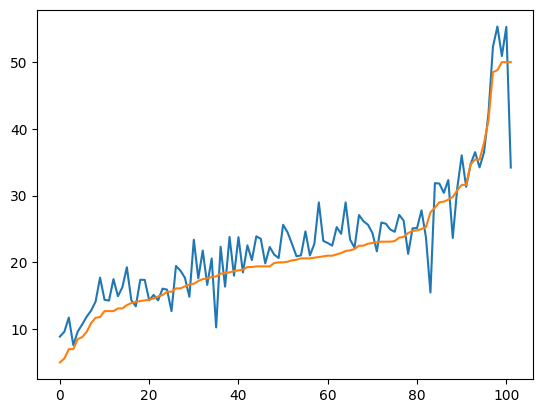

In [15]:
plt.plot(predictions[:,0][np.argsort(y_test.values)])
plt.plot(np.sort(y_test.values))

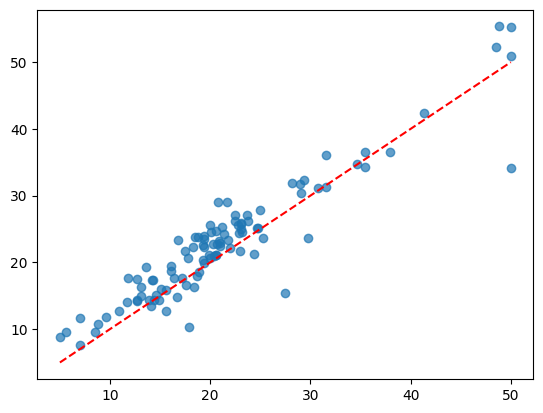

In [16]:
plt.scatter(y_test, predictions, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')